<a href="https://colab.research.google.com/github/udothemath/ncku_customer_embedding/blob/main/WenMing/2_Logistic_Regression_user_profile_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 使用 Logistic Regression 作為 Basline ，且改預測使用者的屬性
* 因為預測消費金額，目前資料解釋力尚不足，故原的 Y 值定義在此 Notebook 中會被修改
* 改為預測使用者屬性作為 Baseline 來驗證這些 feature 是否具有足夠的代表力
* 且避免使用過度複雜模型


In [1]:
# 如果有使用 coloab 再執行此 cell
from google.colab import drive
drive.mount('/gdrive')
!ln -s /gdrive/MyDrive/colab/NCKU_embedding/data/ ./data

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
ln: failed to create symbolic link './data/data': File exists


In [2]:
from google.colab import auth
auth.authenticate_user()

In [3]:
from google.cloud import bigquery

# https://cloud.google.com/resource-manager/docs/creating-managing-projects
project_id = 'neat-motif-123006'
client = bigquery.Client(project=project_id)


In [4]:
# 只拿 x_train 來作 user profile 驗證，因為 x_test 的資料筆數可能無法 train 出好的 embedding
sql = """
SELECT
chid,
avg(monin) as monin ,
avg(wrky) as wrky ,
avg(first_mob) as first_mob ,
avg(cycam) as cycam ,
avg(slam) as slam ,
avg(sum_area_c) as sum_area_c ,
avg(sum_u2_ind) as sum_u2_ind ,
avg(sum_u3_ind) as sum_u3_ind ,
avg(sum_u4_ind) as sum_u4_ind ,
avg(sum_l2_ind) as sum_l2_ind ,
avg(sum_l3_ind) as sum_l3_ind ,
avg(sum_l4_ind) as sum_l4_ind ,
avg(constant_area_c) as constant_area_c ,
avg(constant_u2_ind) as constant_u2_ind ,
avg(constant_u3_ind) as constant_u3_ind ,
avg(constant_u4_ind) as constant_u4_ind ,
avg(constant_l2_ind) as constant_l2_ind ,
avg(constant_l3_ind) as constant_l3_ind ,
avg(constant_l4_ind) as constant_l4_ind ,
avg(constant_change) as constant_change ,
avg(growth_rate) as  growth_rate,
avg(monotone_up) as monotone_up ,
avg(monotone_down) as monotone_down ,
avg(objam) as objam
FROM
  `neat-motif-123006.crd.Normal_0_x_train`
group by chid
"""
x_train = client.query(sql).to_dataframe()

In [5]:
import os
import numpy as np
import pandas as pd
from time import time
from tqdm.notebook import tqdm
from sklearn.preprocessing import MinMaxScaler


import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, auc, roc_auc_score,f1_score

In [6]:
import pickle
with open("./data/sample_50k/valid_user_masts.pkl","rb") as fr:
    valid_user_masts= pickle.load(fr)
valid_user_masts.head(2)

,chid,masts
0,0,1
1,1,1


In [7]:
valid_user_masts = valid_user_masts.set_index('chid')
valid_user_masts = valid_user_masts.sort_index()

In [8]:
# filtering user by valid list 
x_train = x_train[x_train.chid.isin(valid_user_masts.index)]
x_train = x_train.set_index('chid')
x_train = x_train.sort_index()

In [9]:
from sklearn.preprocessing import OneHotEncoder

In [10]:
sample_path = './data/sample_50k'
shift = 0
# x_train = pd.read_csv(os.path.join(sample_path, 'Normal_%d'%shift, 'x_train.csv'), encoding='utf-8')
# x_test = pd.read_csv(os.path.join(sample_path, 'Normal_%d'%shift, 'x_test.csv'), encoding='utf-8')
# y_train = pd.read_csv(os.path.join(sample_path, 'Normal_%d'%shift, 'y_train.csv'), encoding='utf-8')
# y_test = pd.read_csv(os.path.join(sample_path, 'Normal_%d'%shift, 'y_test.csv'), encoding='utf-8')

# chid_mapper = np.load(os.path.join(sample_path, 'sample_idx_map.npy'), allow_pickle=True).item()
# feat_mapper = np.load(os.path.join(sample_path, 'Normal_%d'%shift, 'feature_map.npy'), allow_pickle=True).item()
feature = np.load(os.path.join(sample_path, 'Normal_%d'%shift, 'feature.npy'), allow_pickle=True).item()

category_cols = feature['category_columns']
numeric_cols = feature['numeric_columns']

# print(x_train.shape, x_test.shape, y_train.shape, y_test.shape, len(chid_mapper), [(k, len(v)) for k, v in feat_mapper.items()])

In [11]:
user_list_train = x_train.index 


In [12]:
x_train.head(1)

,monin,wrky,first_mob,cycam,slam,sum_area_c,sum_u2_ind,sum_u3_ind,sum_u4_ind,sum_l2_ind,sum_l3_ind,sum_l4_ind,constant_area_c,constant_u2_ind,constant_u3_ind,constant_u4_ind,constant_l2_ind,constant_l3_ind,constant_l4_ind,constant_change,growth_rate,monotone_up,monotone_down,objam
chid,,,,,,,,,,,,,,,,,,,,,,,,
0,982800.0,0.0,201.0,5200000.0,5.429956e+06,2.888889,0.888889,0.444444,0.555556,1.222222,0.0,0.0,1.777778,0.333333,0.0,0.111111,0.333333,0.0,0.0,0.222222,1.011111,0.666667,1.0,291758.444444


In [20]:
x_final = pd.concat([valid_user_masts,x_train],axis=1)
x_final.head(2)

,masts,monin,wrky,first_mob,cycam,slam,sum_area_c,sum_u2_ind,sum_u3_ind,sum_u4_ind,sum_l2_ind,sum_l3_ind,sum_l4_ind,constant_area_c,constant_u2_ind,constant_u3_ind,constant_u4_ind,constant_l2_ind,constant_l3_ind,constant_l4_ind,constant_change,growth_rate,monotone_up,monotone_down,objam
chid,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,982800.0,0.0,201.0,5200000.0,5.429956e+06,2.888889,0.888889,0.444444,0.555556,1.222222,0.0,0.0,1.777778,0.333333,0.000000,0.111111,0.333333,0.0,0.0,0.222222,1.011111,0.666667,1.000000,291758.444444
1,1,405694.0,32.0,109.0,1092000.0,1.092000e+06,1.888889,0.222222,0.444444,1.777778,1.666667,0.0,0.0,0.222222,0.000000,0.111111,1.555556,0.888889,0.0,0.0,0.000000,1.322222,0.111111,3.555556,109753.666667


## 進行 Feature Selection
* 先對 data 作 normalizing
* 使用 chi squre 來看一下相依性

## 選取所需要的 column 
<span style="color:red">（！！記得修改預設的 Y Colunm）</span>


In [21]:
sparse_feat = category_cols[0:]
dollar_feat = ['monin', 'cycam', 'slam', 'objam']

In [22]:
# x_data dollar value should be transformed by log function

x_final[dollar_feat] = np.log1p(x_final[dollar_feat])

assert x_final.isna().sum().sum()==0 

In [23]:
x_scaler = MinMaxScaler(feature_range=(0, 1))
x_final[numeric_cols] = x_scaler.fit_transform(x_final[numeric_cols])
x_final[numeric_cols].head(2)



,monin,wrky,first_mob,cycam,slam,sum_area_c,sum_u2_ind,sum_u3_ind,sum_u4_ind,sum_l2_ind,sum_l3_ind,sum_l4_ind,constant_area_c,constant_u2_ind,constant_u3_ind,constant_u4_ind,constant_l2_ind,constant_l3_ind,constant_l4_ind,constant_change,growth_rate,monotone_up,monotone_down,objam
chid,,,,,,,,,,,,,,,,,,,,,,,,
0,0.704341,0.000000,0.637540,0.905735,0.893002,0.481481,0.363636,0.235294,0.142857,0.392857,0.0,0.0,0.296296,0.2,0.000000,0.028571,0.130435,0.0,0.0,0.037037,0.308077,0.176471,0.166667,0.742054
1,0.659175,0.062016,0.339806,0.814328,0.800640,0.314815,0.090909,0.235294,0.457143,0.535714,0.0,0.0,0.037037,0.0,0.090909,0.400000,0.347826,0.0,0.0,0.000000,0.308086,0.029412,0.592593,0.684400


## 根據下圖的 correlation matric 分析有以下初步判定
* user profile feature 與數值型(金錢消費) feature 相關性普遍低，推判目前的 feature enginerring 尚不足以來作為使用者分群的來源依據
* 銷費總額(objam) 與 簽帳連續(monotone_up/monotone_down) 具有較有相關性，這也符合邏輯


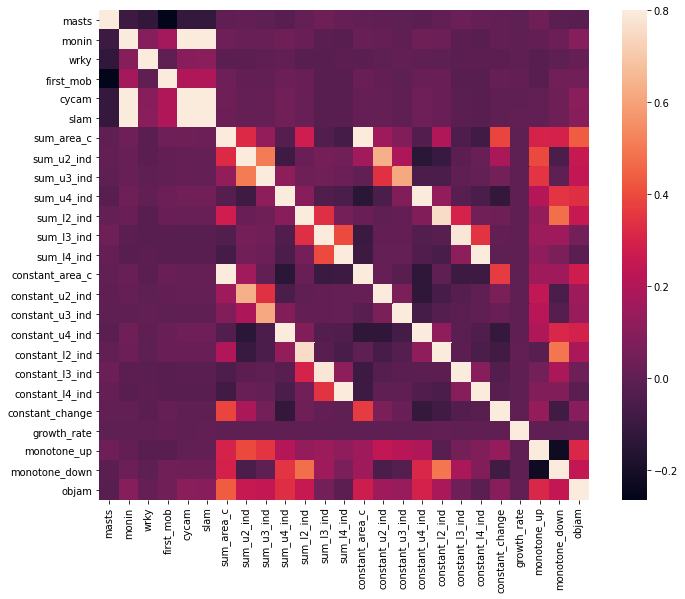

In [24]:
#correlation matrix
corrmat = x_final.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

# 試作使用分類
* 教育程度(educd),婚姻狀態(masts),行業別(trdtp)

# 婚姻狀況
* 結論: 在 training data, 效果還算可以達到 0.68，但是在 testing data 中效果不盡理想。
* 有些使用者的婚姻狀態有改變，所以需要過濾掉一些(已經透過 BigQuery 進行過濾了)

In [27]:
y = x_final.masts
del x_final['masts']
x_final

,monin,wrky,first_mob,cycam,slam,sum_area_c,sum_u2_ind,sum_u3_ind,sum_u4_ind,sum_l2_ind,sum_l3_ind,sum_l4_ind,constant_area_c,constant_u2_ind,constant_u3_ind,constant_u4_ind,constant_l2_ind,constant_l3_ind,constant_l4_ind,constant_change,growth_rate,monotone_up,monotone_down,objam
chid,,,,,,,,,,,,,,,,,,,,,,,,
0,0.704341,0.000000,0.637540,0.905735,0.893002,0.481481,0.363636,0.235294,0.142857,0.392857,0.0000,0.000000,0.296296,0.200000,0.000000,0.028571,0.130435,0.000000,0.0,0.037037,0.308077,0.176471,0.166667,0.742054
1,0.659175,0.062016,0.339806,0.814328,0.800640,0.314815,0.090909,0.235294,0.457143,0.535714,0.0000,0.000000,0.037037,0.000000,0.090909,0.400000,0.347826,0.000000,0.0,0.000000,0.308086,0.029412,0.592593,0.684400
2,0.568249,0.000000,0.165049,0.811471,0.803319,0.518519,0.409091,0.294118,0.000000,0.250000,0.2500,0.043478,0.277778,0.066667,0.272727,0.000000,0.086957,0.153846,0.0,0.037037,0.308076,0.176471,0.203704,0.544789
3,0.629559,0.036822,0.009709,0.770873,0.757915,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.308047,0.000000,0.000000,0.000000
4,0.634234,0.000000,0.760518,0.811471,0.812939,0.333333,0.181818,0.235294,0.057143,0.285714,0.0000,0.000000,0.092593,0.066667,0.000000,0.000000,0.260870,0.000000,0.0,0.000000,0.308071,0.058824,0.407407,0.550007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0.617691,0.000000,0.708738,0.794621,0.781264,0.111111,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.308051,0.029412,0.000000,0.529950
49996,0.621851,0.000000,0.734628,0.822149,0.821179,0.796296,0.227273,0.000000,0.000000,0.214286,0.0000,0.000000,0.574074,0.200000,0.000000,0.000000,0.260870,0.000000,0.0,0.000000,0.308071,0.000000,0.518519,0.661507
49997,0.632783,0.050388,0.016181,0.808466,0.806953,0.370370,0.090909,0.000000,0.114286,0.250000,0.1875,0.000000,0.296296,0.000000,0.000000,0.114286,0.000000,0.230769,0.0,0.018519,0.308079,0.058824,0.425926,0.600190


## Train Test Split

In [39]:
from sklearn.model_selection import train_test_split


In [40]:
X_train, X_test, y_train, y_test = train_test_split(
    x_final, y, test_size=0.33, random_state=42)

## Retain those rows which masts status is 1 and 3 

In [42]:
# 利用 chi squre 找出好的 feature
k=5
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
selector = SelectKBest(chi2, k=k)
selector.fit(X_train, y_train)


new_cols_set = set()
for ci in selector.get_support(indices=True):
    # print(x_train_masts.columns[ci])
    new_cols_set.add(X_train.columns[ci])
new_cols_set

{'cycam', 'first_mob', 'monin', 'slam', 'wrky'}

In [45]:
X_train = X_train[new_cols_set]
X_test = X_test[new_cols_set]

## Train Classifier and Evaluation

In [46]:
print(X_train.shape , y_train.shape)
# print(x_test_oh.shape, y_test.shape)

(33416, 5) (33416,)


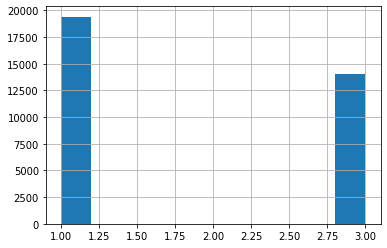

In [47]:
y_train.hist()

In [48]:
# train classifier
t0 = time()
# svr = LinearRegression()
classifier = LogisticRegression(penalty='l1',solver='saga')
classifier.fit(X_train, y_train)
t1 = time()

print('cost: {:.2f}'.format(t1 - t0))

cost: 0.12


### Training Data Performance

In [49]:
predict_y = classifier.predict(X_train)
predict_y_prb = classifier.predict_proba(X_train)


print("Select Columns:",list(new_cols_set))
print("accuracy_score", accuracy_score(y_train,predict_y))
print("confusion_matrix\n", confusion_matrix(y_train,predict_y))
print("roc_auc_score", roc_auc_score(y_train,predict_y_prb[:,1]))
# auc(y_train_masts,predict_y_prb)

Select Columns: ['monin', 'wrky', 'slam', 'first_mob', 'cycam']
accuracy_score 0.6474144122576011
confusion_matrix
 [[14328  5082]
 [ 6700  7306]]
roc_auc_score 0.6836687860939556


### Testing Data Performance

In [50]:
predict_y = classifier.predict(X_test)
predict_y_prb = classifier.predict_proba(X_test)


print("Select Columns:",list(new_cols_set))
print("accuracy_score", accuracy_score(y_test,predict_y))
print("confusion_matrix\n", confusion_matrix(y_test,predict_y))
print("roc_auc_score", roc_auc_score(y_test,predict_y_prb[:,1]))
# auc(y_train_masts,predict_y_prb)

Select Columns: ['monin', 'wrky', 'slam', 'first_mob', 'cycam']
accuracy_score 0.6481166464155529
confusion_matrix
 [[7039 2530]
 [3262 3629]]
roc_auc_score 0.6822214790210959
